# 3. Optimizations

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam

# Visualization tools
import matplotlib.pyplot as plt
from torchview import draw_graph
import graphviz
from IPython.display import Image

# User defined libraries
from utils import other_utils
from utils import ddpm_utils

IMG_SIZE = 16
IMG_CH = 1
BATCH_SIZE = 128
data, dataloader = other_utils.load_transformed_fashionMNIST(IMG_SIZE, BATCH_SIZE)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

100%|██████████| 26421880/26421880 [00:02<00:00, 13000731.79it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 327239.98it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5992138.51it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 11038996.42it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



We have created a [ddpm_util.py](ddpm_utils.py) with a `DDPM` class to group our diffusion functions. Let's use it to set up the same Beta schedule as what we used previously.

In [2]:
nrows = 10
ncols = 15

T = nrows * ncols
B_start = 0.0001
B_end = 0.02
B = torch.linspace(B_start, B_end, T).to(device)
ddpm = ddpm_utils.DDPM(B, device)

In [3]:
class GELUConvBlock(nn.Module):
    def __init__(
        self, in_ch, out_ch, group_size):
        super().__init__()
        layers = [
            nn.Conv2d(in_ch, out_ch, 3, 1, 1),
            nn.GroupNorm(group_size, out_ch),
            nn.GELU()
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [4]:
from einops.layers.torch import Rearrange

rearrange = Rearrange("b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2)

test_image = [
    [
        [
            [1, 2, 3, 4, 5, 6],
            [7, 8, 9, 10, 11, 12],
            [13, 14, 15, 16, 17, 18],
            [19, 20, 21, 22, 23, 24],
            [25, 26, 27, 28, 29, 30],
            [31, 32, 33, 34, 35, 36],
        ]
    ]
]
test_image = torch.tensor(test_image)
print(test_image)
output = rearrange(test_image)
output

tensor([[[[ 1,  2,  3,  4,  5,  6],
          [ 7,  8,  9, 10, 11, 12],
          [13, 14, 15, 16, 17, 18],
          [19, 20, 21, 22, 23, 24],
          [25, 26, 27, 28, 29, 30],
          [31, 32, 33, 34, 35, 36]]]])


tensor([[[[ 1,  3,  5],
          [13, 15, 17],
          [25, 27, 29]],

         [[ 2,  4,  6],
          [14, 16, 18],
          [26, 28, 30]],

         [[ 7,  9, 11],
          [19, 21, 23],
          [31, 33, 35]],

         [[ 8, 10, 12],
          [20, 22, 24],
          [32, 34, 36]]]])

In [5]:
class RearrangePoolBlock(nn.Module):
    def __init__(self, in_chs, group_size):
        super().__init__()
        self.rearrange = Rearrange("b c (h p1) (w p2) -> b (c p1 p2) h w", p1=2, p2=2)
        self.conv = GELUConvBlock(4 * in_chs, in_chs, group_size)

    def forward(self, x):
        x = self.rearrange(x)
        return self.conv(x)

In [6]:
class DownBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super(DownBlock, self).__init__()
        layers = [
            GELUConvBlock(in_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            RearrangePoolBlock(out_chs, group_size)
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

**TODO**: There's an input to the `UpBlock` that makes separates it from the `DownBlock`. What was it again?

If needed, click the `...` below for the correct answer.

In [7]:
class UpBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super(UpBlock, self).__init__()
        layers = [
            nn.ConvTranspose2d(2 * in_chs, out_chs, 2, 2),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x

In [8]:
import math

class SinusoidalPositionEmbedBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [9]:
class EmbedBlock(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedBlock, self).__init__()
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
            nn.Unflatten(1, (emb_dim, 1, 1))
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)

In [10]:
class ResidualConvBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super().__init__()
        self.conv1 = GELUConvBlock(in_chs, out_chs, group_size)
        self.conv2 = GELUConvBlock(out_chs, out_chs, group_size)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        out = x1 + x2
        return out

In [11]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        img_chs = IMG_CH
        down_chs = (64, 64, 128)
        up_chs = down_chs[::-1]  # Reverse of the down channels
        latent_image_size = IMG_SIZE // 4 # 2 ** (len(down_chs) - 1)
        t_dim = 8
        group_size_base = 4
        small_group_size = 2 * group_size_base # New
        big_group_size = 8 * group_size_base  # New
        

        # Inital convolution
        self.down0 = ResidualConvBlock(img_chs, down_chs[0], small_group_size) # New

        # Downsample
        self.down1 = DownBlock(down_chs[0], down_chs[1], big_group_size) # New
        self.down2 = DownBlock(down_chs[1], down_chs[2], big_group_size) # New
        self.to_vec = nn.Sequential(nn.Flatten(), nn.GELU())
        
        # Embeddings
        self.dense_emb = nn.Sequential(
            nn.Linear(down_chs[2]*latent_image_size**2, down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[2]*latent_image_size**2),
            nn.ReLU()
        )

        self.sinusoidaltime = SinusoidalPositionEmbedBlock(t_dim) # New
        self.temb_1 = EmbedBlock(t_dim, up_chs[0])
        self.temb_2 = EmbedBlock(t_dim, up_chs[1])
        
        # Upsample
        self.up0 = nn.Sequential(
            nn.Unflatten(1, (up_chs[0], latent_image_size, latent_image_size)),
            GELUConvBlock(up_chs[0], up_chs[0], big_group_size) # New
        )
        self.up1 = UpBlock(up_chs[0], up_chs[1], big_group_size) # New
        self.up2 = UpBlock(up_chs[1], up_chs[2], big_group_size) # New

        # Match output channels and one last concatenation
        self.out = nn.Sequential(
            nn.Conv2d(2 * up_chs[-1], up_chs[-1], 3, 1, 1),
            nn.GroupNorm(small_group_size, up_chs[-1]), # New
            nn.ReLU(),
            nn.Conv2d(up_chs[-1], img_chs, 3, 1, 1)
        )

    def forward(self, x, t):
        down0 = self.down0(x)
        down1 = self.down1(down0)
        down2 = self.down2(down1)
        latent_vec = self.to_vec(down2)
        
        latent_vec = self.dense_emb(latent_vec)
        t = t.float() / T  # Convert from [0, T] to [0, 1]
        t = self.sinusoidaltime(t) # New
        temb_1 = self.temb_1(t)
        temb_2 = self.temb_2(t)

        up0 = self.up0(latent_vec)
        up1 = self.up1(up0+temb_1, down2)
        up2 = self.up2(up1+temb_2, down1)
        return self.out(torch.cat((up2, down0), 1)) # New

In [12]:
model = UNet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model = torch.compile(model.to(device))

Num params:  1979777


Epoch 0 | step 000 Loss: 1.2591099739074707 


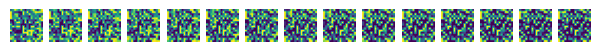

Epoch 0 | step 100 Loss: 0.16299289464950562 


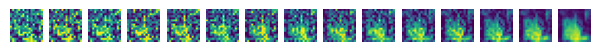

Epoch 0 | step 200 Loss: 0.13128787279129028 


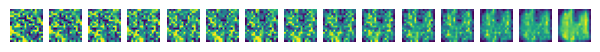

Epoch 0 | step 300 Loss: 0.1534470170736313 


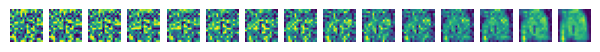

Epoch 0 | step 400 Loss: 0.13614024221897125 


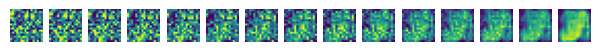

Epoch 0 | step 500 Loss: 0.10658815503120422 


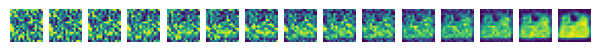

Epoch 1 | step 000 Loss: 0.10700094699859619 


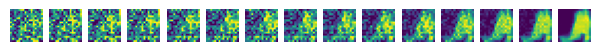

Epoch 1 | step 100 Loss: 0.12480767071247101 


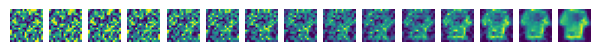

Epoch 1 | step 200 Loss: 0.12532010674476624 


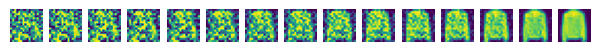

Epoch 1 | step 300 Loss: 0.09549486637115479 


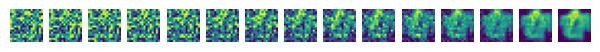

Epoch 1 | step 400 Loss: 0.11335337162017822 


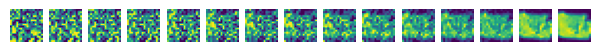

Epoch 1 | step 500 Loss: 0.11272908002138138 


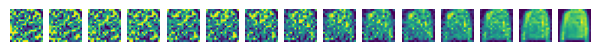

Epoch 2 | step 000 Loss: 0.11028440296649933 


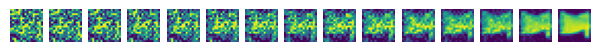

Epoch 2 | step 100 Loss: 0.09189222753047943 


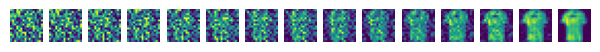

Epoch 2 | step 200 Loss: 0.08672645688056946 


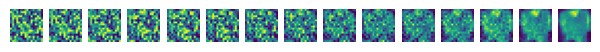

Epoch 2 | step 300 Loss: 0.09616386890411377 


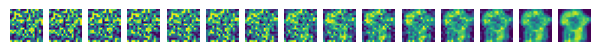

Epoch 2 | step 400 Loss: 0.10532359778881073 


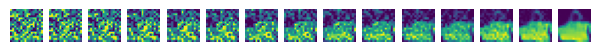

Epoch 2 | step 500 Loss: 0.09751153737306595 


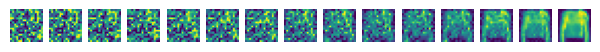

Epoch 3 | step 000 Loss: 0.09518801420927048 


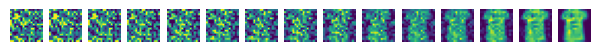

Epoch 3 | step 100 Loss: 0.0897618904709816 


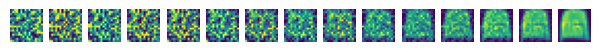

Epoch 3 | step 200 Loss: 0.08893679082393646 


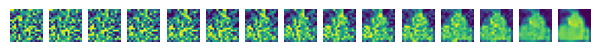

Epoch 3 | step 300 Loss: 0.09268888831138611 


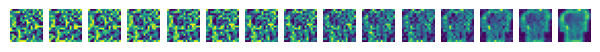

Epoch 3 | step 400 Loss: 0.08372154831886292 


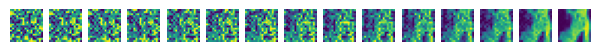

Epoch 3 | step 500 Loss: 0.10674148797988892 


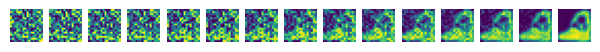

Epoch 4 | step 000 Loss: 0.10145233571529388 


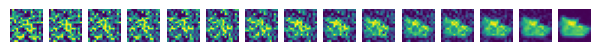

Epoch 4 | step 100 Loss: 0.0850805789232254 


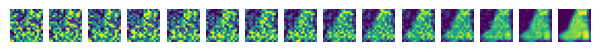

Epoch 4 | step 200 Loss: 0.08863195031881332 


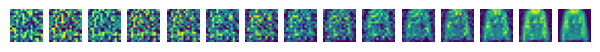

Epoch 4 | step 300 Loss: 0.09977758675813675 


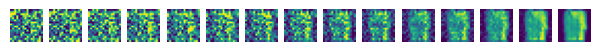

Epoch 4 | step 400 Loss: 0.11168152093887329 


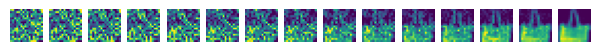

Epoch 4 | step 500 Loss: 0.07670974731445312 


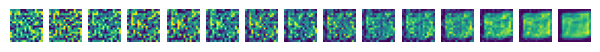

In [13]:
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 5

model.train()
for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()

        t = torch.randint(0, T, (BATCH_SIZE,), device=device).float()
        x = batch[0].to(device)
        loss = ddpm.get_loss(model, x, t)
        loss.backward()
        optimizer.step()

        if epoch % 1 == 0 and step % 100 == 0:
            print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
            ddpm.sample_images(model, IMG_CH, IMG_SIZE, ncols)

<Figure size 800x800 with 0 Axes>

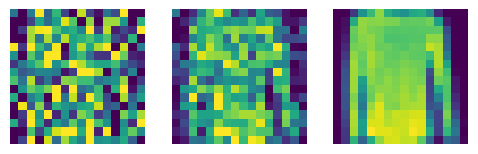

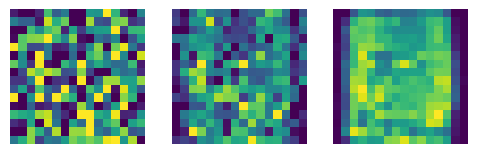

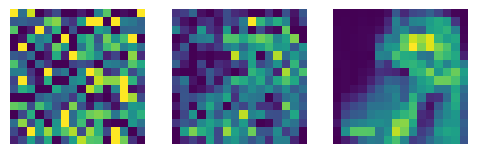

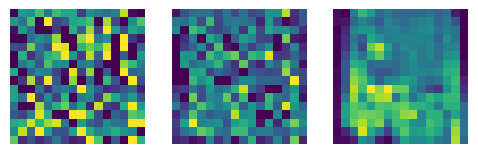

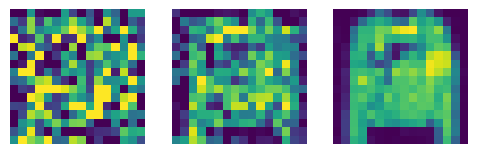

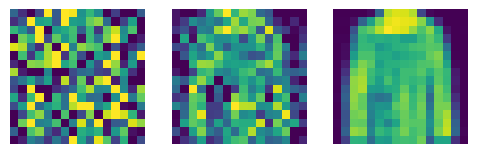

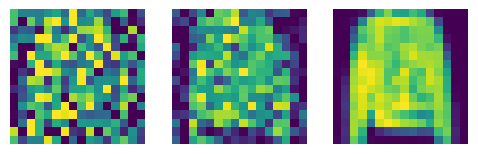

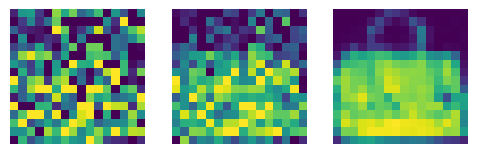

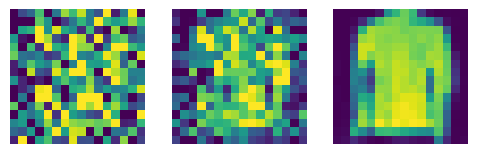

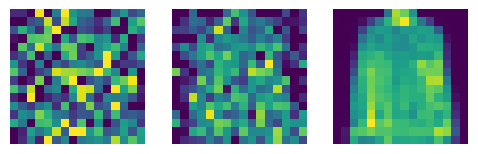

In [14]:
model.eval()
plt.figure(figsize=(8,8))
ncols = 3 # Should evenly divide T
for _ in range(10):
    ddpm.sample_images(model, IMG_CH, IMG_SIZE, ncols)

In [15]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}